## **Emergency Vehicle Detection**
### Background:
The essence of emergency vehicle identification is to quickly and accurately detect emergency
vehicles (e.g., ambulances, police cars, fire trucks) to allow for immediate clearance on roads
and prioritized response. In this project, we will develop a Convolutional Neural Network
(CNN) model to classify emergence and non-emergence vehicles

The dataset for this project can be found here: [Emergency Vehicle Identification(Kaggle.com)](https://www.kaggle.com/datasets/abhisheksinghblr/emergency-vehicles-identification?resource=download)

### **Import relevant libraries for this project**

We must first import all the libraries and load the dataset we will be needing for this project


In [1]:
# import Libraries
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### **Data loading, Preprocessing and Tranformation for Augmentation**
We must load our dataset for the image classification problems. We need to also augment our dataset, which involves applying random transformations such as rotations,flipping etc to the images.

In [2]:
# save directory to dataset

train_dir = 'C:/Users/Ghost/Desktop/Emergency_Vehicles/train'
test_dir = 'C:/Users/Ghost/Desktop/Emergency_Vehicles/test'

In [3]:
# set up ImageDataGenerators with augmentation for training data

train_datagen = ImageDataGenerator(
    rescale=1./255,                # normalize pixel values to range between 0 and 1
    rotation_range=20,             # randomly rotate images up to 20 degrees
    width_shift_range=0.1,         # randomly shift images horizontally up to 10% of the width
    height_shift_range=0.1,        # randomly shift images vertically up to 10% of the height
    shear_range=0.1,               # crop part of the image
    zoom_range=0.1,                # zoom the image by 10%
    horizontal_flip=True,          # Random horizontal flip
    brightness_range=[0.8, 1.2],   # make brightness range between 0.8 and 1.2
    validation_split=0.2           # 20% for validation
)

# no augmentation required for testing data, so we just normalize pixel values
    
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# load the images for training, validation and testing

train_generator = train_datagen.flow_from_directory(
    train_dir,                      # training set directory 
    target_size=(32, 32),           # resize image to 32x32
    batch_size = 16,                # specify batch size
    class_mode='binary',            # use 'binary' for binary classification, which works for one-class problems
    shuffle=True                    # shuffle images for better training
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,                      # same dataset, but for validation
    target_size=(32,32),
    batch_size = 16,                # specify batch size
    class_mode='binary',
    subset='validation'             # specify validation subset
)

test_generator = test_datagen.flow_from_directory(
    test_dir,                       # testing set directory
    target_size=(32, 32),           # resize images to 32x32
    batch_size = 16,                # specify batch size
    class_mode='binary',            # use 'binary' for binary classification, which works for one-class problems
    shuffle=False                   # no shuffle for testing
)

Found 1646 images belonging to 2 classes.
Found 329 images belonging to 2 classes.
Found 706 images belonging to 2 classes.


##### Confirm class indices for all generators

In [5]:
print('Train class indices:', train_generator.class_indices)
print('Test class indices:', test_generator.class_indices)
print('Validation Class indices:', validation_generator.class_indices)

Train class indices: {'emergency': 0, 'non_emergency': 1}
Test class indices: {'emergency': 0, 'non_emergency': 1}
Validation Class indices: {'emergency': 0, 'non_emergency': 1}


### **Model Building**
We now have everything we need to build our model, but before we proceed we must first define the architecture for the model we wish to build

##### CNN Model Architecture
* First, a 2-dimensional Convolution layer (Conv2D) with 32 filters, input size of 32,32,3, a kernel size of 3x3, and the ReLU activation function.
* A 2-dimensional Max Pooling layer (MaxPooling2D) with a pool size of 2x2.
* A second 2-dimensional Convolution layer with 64 filters, a kernel size of 3x3, and the ReLU activation function.
* A 2-dimensional Max Pooling layer (MaxPooling2D) with a pool size of 2x2.
* A third 2-dimensional Convolution layer with 128 filters, a kernel size of 3x3, and the ReLU activation function.
* A 2-dimensional Max Pooling layer (MaxPooling2D) with a pool size of 2x2.
* A Flatten layer, which will flatten the outputs of the final convolution and pooling layers into 1 dimension, ready for the fully connected part
of the network
* A Dense layer with 64 neurons and the ReLU activation function.
* A 50% dropout layer
* A final Dense layer with 1 neuron and the Sigmoid activation function. The outputs from this layer is a single 0 or 1 class hence the use of sigmoid

In [6]:
# define the Model

# instantiate sequential model
model = Sequential()

# add input shape
model.add(Input(shape=(32,32,3)))

# add first convolutional and maxpooling layers specifying parameters
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))


# add second convulational and maxpooling layers
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))


# add third convolutional and maxpooling layers
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))


# add flatten layer
model.add(Flatten())

# add dense layer
model.add(Dense(64, activation='relu'))

# apply 50% dropout layer
model.add(Dropout(0.5))

# add output layer, with one unit since we have one class and use sigmoid activation
model.add(Dense(1, activation='sigmoid'))

In [7]:
# display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,449 (876.75 KB)

 Trainable params: 224,449 (876.75 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# we introduce aregularization technique Early Stopping with a patience of 5
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
# compile model with a BinaryCrossEntropy loss function, Adam optimizer with a learning rate of 0.0005, and accuracy as evaluation metric
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# train the Model with 25 epochs
history = model.fit(train_generator, validation_data=validation_generator, epochs=25, callbacks=[early_stopping])

Epoch 1/25


C:\Users\Ghost\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5689 - loss: 0.6740 - val_accuracy: 0.7082 - val_loss: 0.5979
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6898 - loss: 0.6032 - val_accuracy: 0.7416 - val_loss: 0.5325
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7213 - loss: 0.5710 - val_accuracy: 0.7325 - val_loss: 0.5832
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7374 - loss: 0.5458 - val_accuracy: 0.7477 - val_loss: 0.5175
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7410 - loss: 0.5461 - val_accuracy: 0.7356 - val_loss: 0.5093
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7569 - loss: 0.5234 - val_accuracy: 0.7660 - val_loss: 0.4828
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7477 - loss: 0.5116 - val_accuracy: 0.8055 - val_loss: 0.4578
Epoch 8/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7726 - loss: 0.4867 - val_accuracy: 0.766

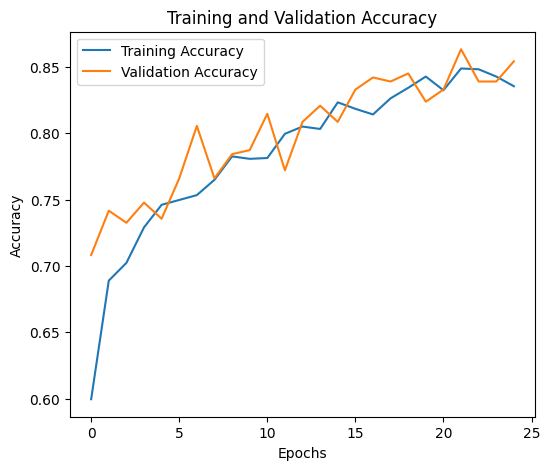

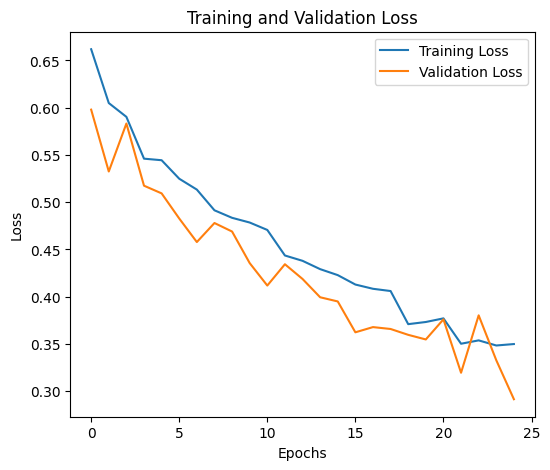

In [11]:
# plot training and validation accuracy

plt.figure(figsize=(6,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot training and validation loss

plt.figure(figsize=(6,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# predictthe test set

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8437 - loss: 0.3572
Test Loss: 0.3472490608692169
Test Accuracy: 0.854107677936554


we get a final accuracy of around 85% and a loss of about 0.35. This is a relatively good result, we can now proceed to testing the model on our test set and evaluate its performance 

### **Model Evaluation**

In [13]:
# predict the classes of the test set

y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)                      # Convert probabilities to binary labels


# print the classification report

print(classification_report(test_generator.classes, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       310
           1       0.88      0.86      0.87       396

    accuracy                           0.85       706
   macro avg       0.85      0.85      0.85       706
weighted avg       0.85      0.85      0.85       706



<Figure size 700x500 with 0 Axes>

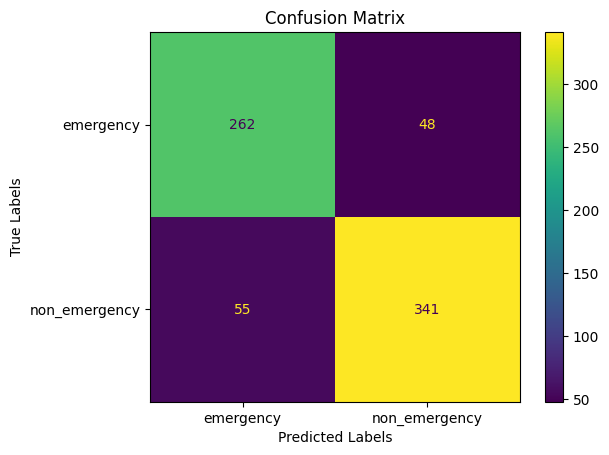

In [14]:
# print the confusion matrix

class_names = ['emergency', 'non_emergency']
cm = confusion_matrix(test_generator.classes, y_pred)
plt3 = plt.figure(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Our model does a good job of classifying emergency vehicles considering the slight class imbalance in our dataset (more non-emergency vehicle instances than emergency). But reducing false positives is critical, we need to identify as much emergency vehicles as possible in order to optimize for higher recall. In future works we will address the class imbalance and employ hyperparameter tuning using GridSearchCV